In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError
    
qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [5]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

(<tf.Tensor: id=975, shape=(1, 24), dtype=float32, numpy=
 array([[0.410683  , 0.5045751 , 0.45263594, 0.7514136 , 0.27805552,
         0.26313874, 0.3000163 , 0.27378327, 0.30726707, 0.25905722,
         0.27302808, 0.2758088 , 0.28475055, 0.2818121 , 0.33656204,
         0.2914981 , 0.30686322, 0.302852  , 0.27715594, 0.30848205,
         0.2921897 , 0.28166628, 0.2747703 , 0.27956322]], dtype=float32)>,
 <tf.Tensor: id=976, shape=(1, 30), dtype=float32, numpy=
 array([[0.02686268, 0.09764964, 0.14367291, 0.19789246, 0.26058832,
         0.33119917, 0.40805736, 0.48839146, 0.5687257 , 0.64558387,
         0.7161947 , 0.77889055, 0.8315982 , 0.8760566 , 0.9499203 ,
         0.12912974, 0.14341198, 0.17071898, 0.16522855, 0.18414998,
         0.19116932, 0.19724475, 0.20174809, 0.19878519, 0.19320019,
         0.18888897, 0.18633626, 0.18757343, 0.19186877, 0.16597912]],
       dtype=float32)>)

In [8]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
#vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )


AEFIT5 a ready:


In [11]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

Epoch 1/50
425/425 [==============================] - 30s 70ms/step - loss: 7.3342e-04 - val_loss: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 30s 71ms/step - loss: 5.7999e-04 - val_loss: 2.9664e-04
Epoch 3/50
425/425 [==============================] - 30s 70ms/step - loss: 5.0664e-04 - val_loss: 3.0667e-04
Epoch 4/50
425/425 [==============================] - 30s 70ms/step - loss: 4.6991e-04 - val_loss: 2.8269e-04
Epoch 5/50
425/425 [==============================] - 31s 72ms/step - loss: 4.3654e-04 - val_loss: 2.9916e-04
Epoch 6/50
425/425 [==============================] - 31s 73ms/step - loss: 4.1709e-04 - val_loss: 2.2100e-04
Epoch 7/50
425/425 [==============================] - 30s 71ms/step - loss: 3.2455e-04 - val_loss: 1.8540e-04
Epoch 8/50
425/425 [==============================] - 30s 70ms/step - loss: 3.0156e-04 - val_loss: 1.6635e-04
Epoch 9/50
425/425 [==============================] - 29s 69ms/step - loss: 2.9047e-04 - val_loss: 1.8029e-04
Epoch 10/5

In [12]:
vae_history

In [18]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=24, dprate=0.01, scale=1, geometry=[40,40,20,20])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [19]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=129520, shape=(1, 24), dtype=float32, numpy=
 array([[0.410683  , 0.5045751 , 0.45263594, 0.7514136 , 0.27805552,
         0.26313874, 0.3000163 , 0.27378327, 0.30726707, 0.25905722,
         0.27302808, 0.2758088 , 0.28475055, 0.2818121 , 0.33656204,
         0.2914981 , 0.30686322, 0.302852  , 0.27715594, 0.30848205,
         0.2921897 , 0.28166628, 0.2747703 , 0.27956322]], dtype=float32)>,
 <tf.Tensor: id=129521, shape=(1, 6), dtype=float32, numpy=
 array([[ 0.03454644, -0.6971418 ,  0.8285051 ,  1.5213149 ,  0.16046114,
          0.19789958]], dtype=float32)>)

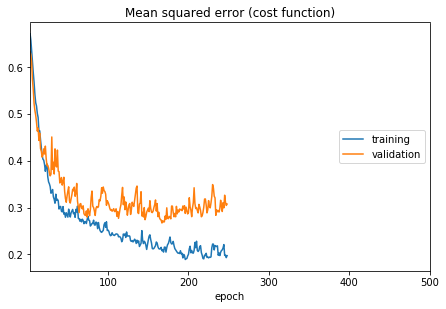

Mean squared error (cost function):
training   (min:    0.189, max:    0.784, cur:    0.198)
validation (min:    0.267, max:    0.668, cur:    0.307)
100/100 [==============================] - 32s 324ms/step - loss: 0.1975 - val_loss: 0.3074
Epoch 249/500
 99/100 [============================>.] - ETA: 0s - loss: 0.1922

KeyboardInterrupt: 

In [20]:

# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.

l1_l2 = tf.keras.regularizers.l1_l2
for l in gen.layers:
    if issubclass(type(l), tf.keras.layers.Dense):
        l.activity_regularizer = l1_l2(0.1)

gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )
print(rel.weights)        
    
# qsh.shuffle()
history = gen.fit( Dds.skip(3000).batch(100).take(100), validation_data=Dds.take(3000).batch(100).take(100), epochs=500,
                  callbacks=[PlotLossesCallback()] )

In [22]:
gen.layers[1].weights

[<tf.Variable 'aefi_t5_8_iRlv/kernel:0' shape=(24,) dtype=float32, numpy=
 array([0.9252038 , 0.92643255, 0.88604283, 0.9142872 , 0.9999999 ,
        0.5014349 , 0.48931277, 0.8115765 , 0.7963875 , 0.18436761,
        0.38097686, 0.5466501 , 0.07242887, 0.37977585, 0.99045277,
        0.41757637, 0.58297706, 0.8610566 , 0.6379011 , 0.404293  ,
        0.77272046, 0.2186094 , 0.00276551, 0.6671001 ], dtype=float32)>]

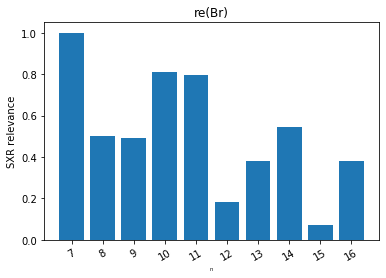

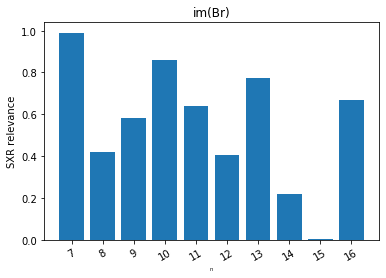

In [21]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')


In [ ]:
# vae.save('step12_gan_PBr_reim')
# vae.load('step12_gan_PBr_reim')

In [23]:
pos = 0

49


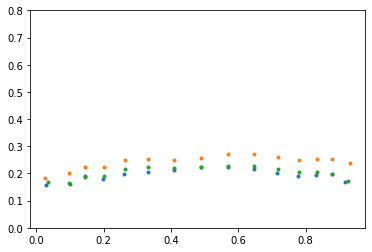

In [73]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy):
    fig = plt.figure('plot')
    ax = plt.gca()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.')
    
    

xy = d_pos[1]
XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot(xy)
plot(XY)
plot(XY_vae)
pos += 1